In [412]:
import os
os.environ["OMP_NUM_THREADS"] = "8"
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import  KMeans
from sklearn.metrics import silhouette_score, adjusted_rand_score
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
import numpy as np

### Читаем датасет

In [413]:
file_path = "dataset.csv"
df = pd.read_csv(file_path)

In [414]:
print(f'Количество строк в DataFrame: {df.shape[0]}')

Количество строк в DataFrame: 2258


### очищаем данные

In [415]:
df = df.drop_duplicates()
df = df.dropna()
print(f'Количество строк в DataFrame: {df.shape[0]}')

Количество строк в DataFrame: 2035


### Нормализация

In [416]:
scaler = StandardScaler()
scaled_data = scaler.fit_transform(df[["Площадь", "Комнаты", "Цена", "Этаж квартиры", "Этажей в доме", "Год сдачи"]])

In [417]:
print(f'Количество строк в DataFrame: {df.shape[0]}')

Количество строк в DataFrame: 2035


## Строим графики

### цена

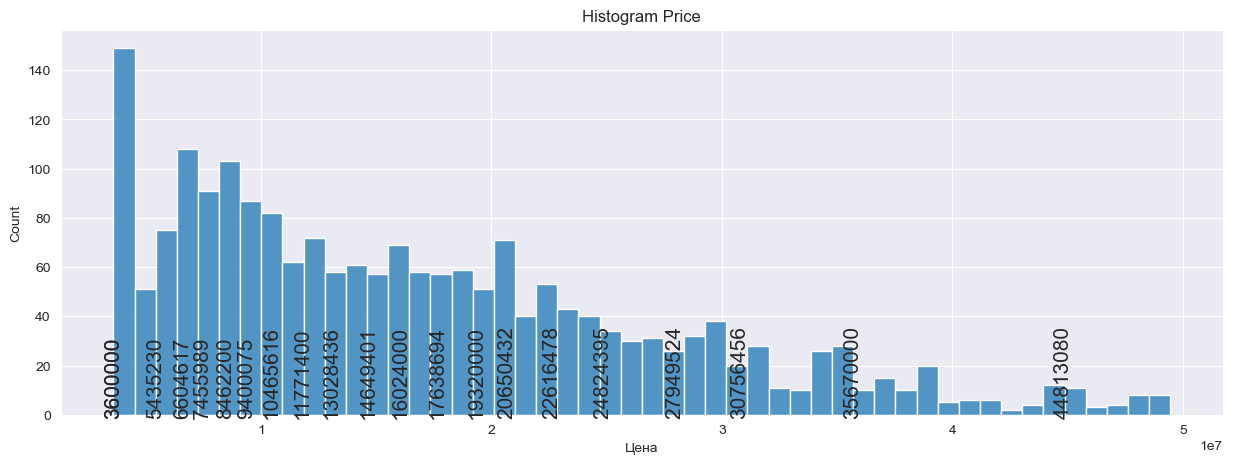

In [418]:
plt.figure(figsize=(15, 5))
sns.histplot(df["Цена"], bins=50, kde=False)
plt.title('Histogram Price')
prices = df["Цена"]
sorted_prices = sorted(prices)
for i, price in enumerate(sorted_prices):
    if i % 100 == 0:
        plt.text(price, 0, str(price), horizontalalignment='center', fontsize=15, rotation=90,)

plt.show()

### комнаты

[1 2 3 6 4 5]


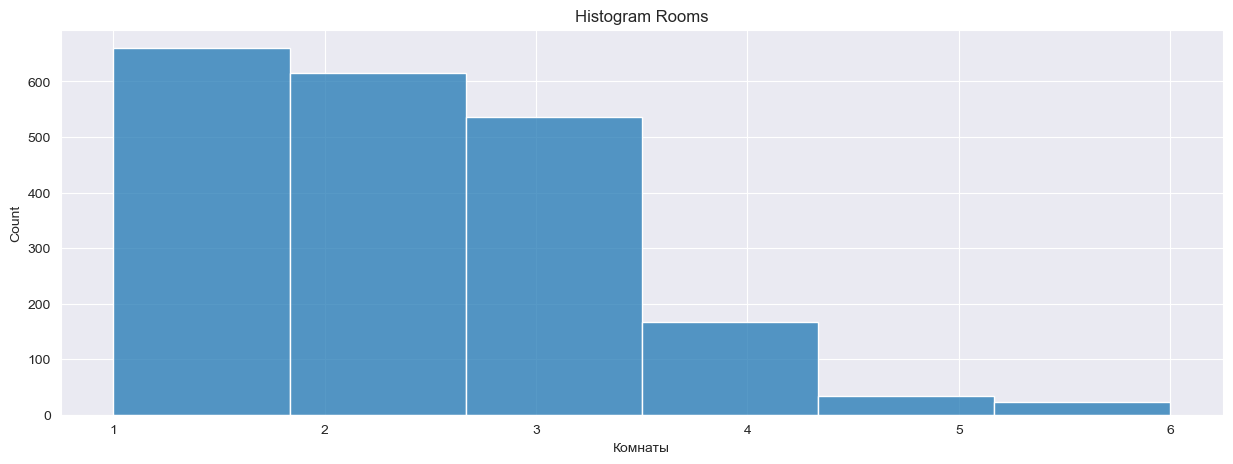

In [419]:
plt.figure(figsize=(15, 5))
sns.histplot(df["Комнаты"], bins=6, kde=False)
plt.title('Histogram Rooms')

rooms = df["Комнаты"].unique()
print(rooms)

plt.show()

### площадь

[177.8   161.    185.    ... 127.959  75.217  25.251]


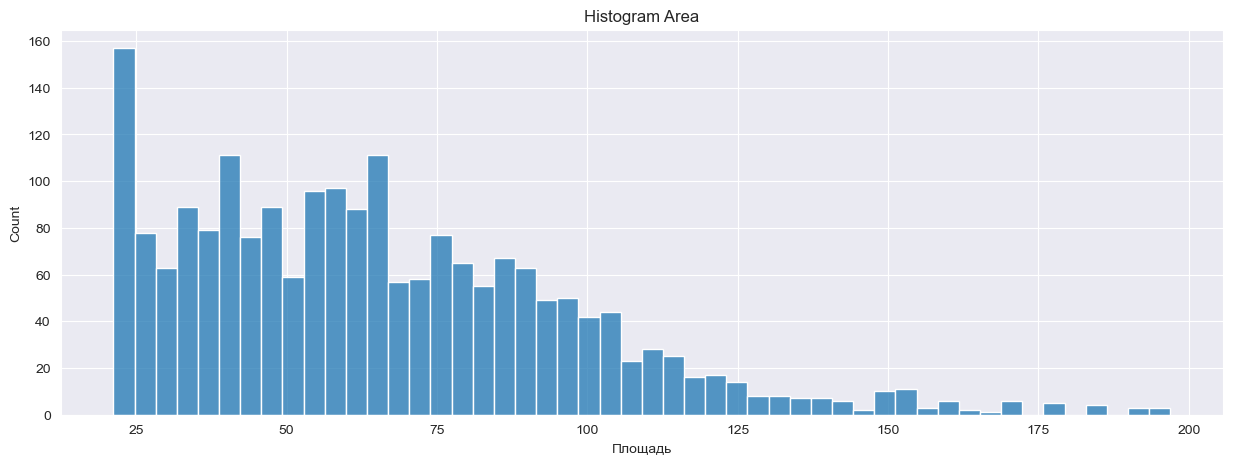

In [420]:
plt.figure(figsize=(15, 5))
sns.histplot(df["Площадь"], bins=50, kde=False)
plt.title('Histogram Area')

areas = df["Площадь"].unique()
print(areas)

plt.show()

### Подготовка признаков

In [421]:
numerical_features = ["Площадь", "Комнаты", "Цена", "Этаж квартиры", "Этажей в доме", "Год сдачи"]
categorical_features = ["Район"]

numerical_transformer = StandardScaler()
categorical_transformer = OneHotEncoder(handle_unknown='ignore', sparse_output=False)

### Создаем ColumnTransformer для применения разных трансформаций к разным столбцам

In [422]:
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)
    ],
    remainder='passthrough'
)

### Дальше работаем с X параметрами

In [423]:

X_processed = preprocessor.fit_transform(df)
try:
    ohe_feature_names = preprocessor.named_transformers_['cat'].get_feature_names_out(categorical_features)
    all_feature_names = numerical_features + list(ohe_feature_names)
    print("\nИмена признаков после предобработки:")
    print(all_feature_names)
except AttributeError:
    print("\nНе удалось получить имена признаков из OneHotEncoder (возможно, старая версия sklearn).")
    all_feature_names = None

print(f"\nРазмерность обработанных данных (X_processed): {X_processed.shape}")

if all_feature_names:
     df_processed = pd.DataFrame(X_processed, columns=all_feature_names, index=df.index)
     print("\nПервые 5 строк обработанных данных:")
     print(df_processed.head())


Имена признаков после предобработки:
['Площадь', 'Комнаты', 'Цена', 'Этаж квартиры', 'Этажей в доме', 'Год сдачи', 'Район_Адмиралтейский', 'Район_Василеостровский', 'Район_Выборгский', 'Район_Калининский', 'Район_Кировский', 'Район_Колпинский', 'Район_Красногвардейский', 'Район_Красносельский', 'Район_Кронштадтский', 'Район_Курортный', 'Район_Московский', 'Район_Невский', 'Район_Петроградский', 'Район_Петродворцовый', 'Район_Приморский', 'Район_Пушкинский', 'Район_Фрунзенский', 'Район_Центральный']

Размерность обработанных данных (X_processed): (2035, 24)

Первые 5 строк обработанных данных:
    Площадь   Комнаты      Цена  Этаж квартиры  Этажей в доме  Год сдачи  \
0  3.448908 -1.090578 -1.104320      -0.964520      -1.099744  -0.093801   
1  2.932939 -0.180645 -1.128199      -1.177613      -0.930483  -1.009322   
2  3.670037 -1.090578 -1.022710      -0.325241      -0.930483   0.363959   
3  2.840802  0.729288 -1.109019       0.953316      -0.930483   0.363959   
4  3.857383  0.7292

### Baseline

ну, инет пишет, что для задач кластеризации бейзлайн не нужен so....

### Обучении модели из фреймворка (K-Means)

### Поиск оптимального K

In [424]:
inertia = []
silhouette_scores = []
k_range = range(2, 16)

for k in k_range:
    kmeans_model = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans_model.fit(X_processed)
    inertia.append(kmeans_model.inertia_)
    silhouette_scores.append(silhouette_score(X_processed, kmeans_model.labels_))

C:\Users\HONOR\miniconda3\envs\workspace\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=8.
  warnings.warn(
C:\Users\HONOR\miniconda3\envs\workspace\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=8.
  warnings.warn(
C:\Users\HONOR\miniconda3\envs\workspace\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=8.
  warnings.warn(
C:\Users\HONOR\miniconda3\envs\workspace\Lib\site-packages\sklearn\cluster\_kmeans.py:14

### Визуализация для выбора K

In [425]:
plt.figure(figsize=(14, 6))

<Figure size 1400x600 with 0 Axes>

<Figure size 1400x600 with 0 Axes>

### Метод Локтя (Elbow Method)

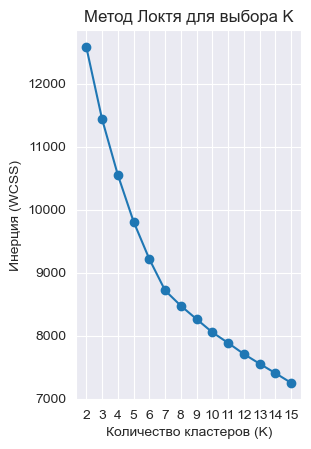

In [426]:
plt.subplot(1, 2, 1)
plt.plot(k_range, inertia, marker='o')
plt.title('Метод Локтя для выбора K')
plt.xlabel('Количество кластеров (K)')
plt.ylabel('Инерция (WCSS)')
plt.xticks(k_range)
plt.grid(True)

### Коэффициент Силуэта

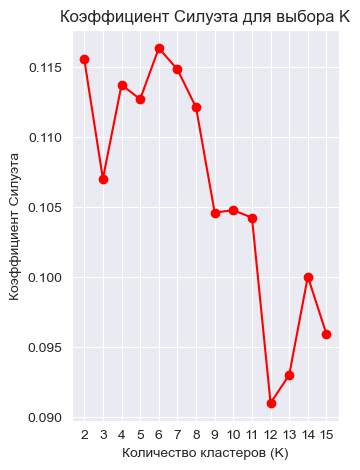

In [427]:
plt.subplot(1, 2, 2)
plt.plot(k_range, silhouette_scores, marker='o', color='r')
plt.title('Коэффициент Силуэта для выбора K')
plt.xlabel('Количество кластеров (K)')
plt.ylabel('Коэффициент Силуэта')
plt.xticks(k_range)
plt.grid(True)
plt.tight_layout()
plt.show()

### Выбор оптимального K

In [428]:
optimal_k = 7
print(f"\nВыбрано оптимальное количество кластеров K = {optimal_k}")


Выбрано оптимальное количество кластеров K = 7


### Обучение финальной модели из фреймворка

In [429]:
kmeans_framework = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
framework_labels = kmeans_framework.fit_predict(X_processed)

df['cluster_framework'] = framework_labels
print("\nРаспределение данных по кластерам (фреймворк):")
print(df['cluster_framework'].value_counts())

C:\Users\HONOR\miniconda3\envs\workspace\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=8.
  warnings.warn(



Распределение данных по кластерам (фреймворк):
cluster_framework
4    402
3    306
0    278
1    268
6    263
5    259
2    259
Name: count, dtype: int64


### Измерим качество модели из фреймворка

In [430]:
framework_silhouette_avg = silhouette_score(X_processed, framework_labels)
print(f"\nСредний коэффициент силуэта (фреймворк, K={optimal_k}): {framework_silhouette_avg:.4f}")

framework_inertia = kmeans_framework.inertia_
print(f"Инерция (WCSS) (фреймворк, K={optimal_k}): {framework_inertia:.2f}")

print("\nСредние значения признаков по кластерам (до масштабирования):")
cluster_analysis = df.groupby('cluster_framework')[numerical_features].mean()
print(cluster_analysis)

print("\nРаспределение районов по кластерам:")
print(pd.crosstab(df['cluster_framework'], df['Район']))


Средний коэффициент силуэта (фреймворк, K=7): 0.1149
Инерция (WCSS) (фреймворк, K=7): 8717.96

Средние значения признаков по кластерам (до масштабирования):
                      Площадь   Комнаты          Цена  Этаж квартиры  \
cluster_framework                                                      
0                   61.599259  2.338129  3.540342e+07       6.471223   
1                   66.092366  1.985075  1.579805e+07       5.238806   
2                  120.440961  2.169884  1.592740e+07       5.111969   
3                   55.229775  3.689542  1.349524e+07       5.035948   
4                   47.430391  1.348259  1.142323e+07       4.353234   
5                   60.179942  1.957529  1.373988e+07      14.718147   
6                   59.746479  2.098859  1.536565e+07       6.277567   

                   Этажей в доме    Год сдачи  
cluster_framework                              
0                      10.366906  2025.669065  
1                      20.750000  2025.503731  
2

### Реализуем K-Means самостоятельно

In [431]:
def euclid_dist_sq(point1, point2):
    return np.sum((point1 - point2)**2)

def init_centroids(X, n_clusters, random_state=None):
    if random_state:
        np.random.seed(random_state)
    n_samples = X.shape[0]
    indices = np.random.choice(n_samples, n_clusters, replace=False)
    return X[indices]

def ass_clusters(X, centroids):
    n_samples = X.shape[0]
    labels = np.zeros(n_samples, dtype=int)
    for i in range(n_samples):
        distances = [euclid_dist_sq(X[i], c) for c in centroids]
        labels[i] = np.argmin(distances)
    return labels

def recalculate_centroids(X, labels, n_clusters):
    n_features = X.shape[1]
    new_centroids = np.zeros((n_clusters, n_features))
    counts = np.zeros(n_clusters)

    for i in range(X.shape[0]):
        cluster_idx = labels[i]
        new_centroids[cluster_idx] += X[i]
        counts[cluster_idx] += 1

    for k in range(n_clusters):
        if counts[k] > 0:
            new_centroids[k] /= counts[k]
        else:
            new_centroids[k] = X[np.random.choice(X.shape[0])]
    return new_centroids

def calc_inertia(X, labels, centroids):
    inertia = 0.0
    for i in range(X.shape[0]):
        inertia += euclid_dist_sq(X[i], centroids[labels[i]])
    return inertia

def manual_kmeans_verbose(X, n_clusters, max_iterations=100, tolerance=1e-4, random_state=None):
    centroids = init_centroids(X, n_clusters, random_state)
    labels = np.zeros(X.shape[0])
    inertia_history = []

    for i in range(max_iterations):
        old_centroids = centroids.copy()
        labels = ass_clusters(X, centroids)
        centroids = recalculate_centroids(X, labels, n_clusters)
        current_inertia = calc_inertia(X, labels, centroids)
        inertia_history.append(current_inertia)

        centroid_shift = np.sum((centroids - old_centroids)**2)
        if centroid_shift < tolerance:
            print(f"Схождение достигнуто на итерации {i+1} (сдвиг центроидов < {tolerance})")
            break
    else:
        print(f"Достигнуто максимальное количество итераций ({max_iterations})")

    final_inertia = calc_inertia(X, labels, centroids)

    return labels, centroids, final_inertia, inertia_history

### Тестирование ручной реализации с оптимальным K

In [432]:
manual_labels, manual_centroids, manual_inertia, manual_inertia_hist = manual_kmeans_verbose(
    X_processed,
    n_clusters=optimal_k,
    max_iterations=300,
    tolerance=1e-4,
    random_state=42
)

Схождение достигнуто на итерации 28 (сдвиг центроидов < 0.0001)


### Визуализация сходимости инерции

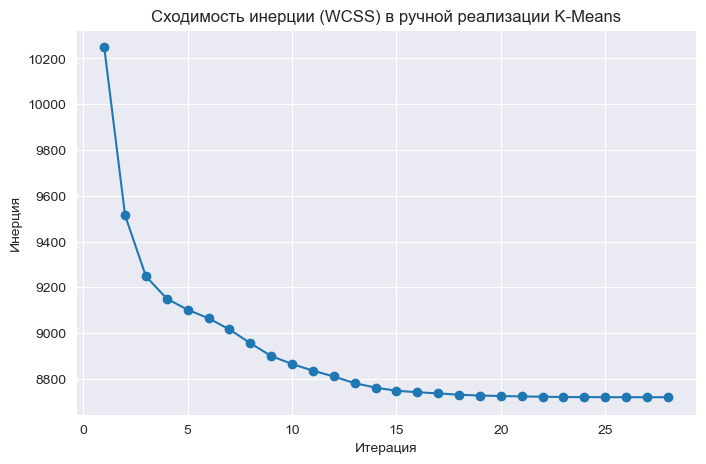

In [433]:
plt.figure(figsize=(8, 5))
plt.plot(range(1, len(manual_inertia_hist) + 1), manual_inertia_hist, marker='o')
plt.title('Сходимость инерции (WCSS) в ручной реализации K-Means')
plt.xlabel('Итерация')
plt.ylabel('Инерция')
plt.grid(True)
plt.show()

## Измерение качества и сравнение моделей

### Оценка качества ручной реализации

In [434]:
manual_silhouette_avg = silhouette_score(X_processed, manual_labels)
print(f"\nСредний коэффициент силуэта (ручная реализация, K={optimal_k}): {manual_silhouette_avg:.4f}")
print(f"Инерция (WCSS) (ручная реализация, K={optimal_k}): {manual_inertia:.2f}")


Средний коэффициент силуэта (ручная реализация, K=7): 0.1149
Инерция (WCSS) (ручная реализация, K=7): 8719.40


### Сравнение с фреймворком

In [435]:
print(f"Силуэт (фреймворк): {framework_silhouette_avg:.4f}")
print(f"Силуэт (ручной):    {manual_silhouette_avg:.4f}")
print(f"Инерция (фреймворк): {framework_inertia:.2f}")
print(f"Инерция (ручной):    {manual_inertia:.2f}")

Силуэт (фреймворк): 0.1149
Силуэт (ручной):    0.1149
Инерция (фреймворк): 8717.96
Инерция (ручной):    8719.40


### Сравнение меток кластеров с помощью Adjusted Rand Index (ARI = 1: идеальное совпадение, ARI = 0: случайное совпадение)

In [436]:
ari = adjusted_rand_score(framework_labels, manual_labels)
print(f"Adjusted Rand Index (ARI) между метками: {ari:.4f}")

Adjusted Rand Index (ARI) между метками: 0.8828


ARI = 0.8828, это близко к единице, значит у нас крутая моделька

In [437]:
df['cluster_manual'] = manual_labels
print(df['cluster_framework'].value_counts().sort_index())
print("\nРучная реализация:")
print(df['cluster_manual'].value_counts().sort_index())

cluster_framework
0    278
1    268
2    259
3    306
4    402
5    259
6    263
Name: count, dtype: int64

Ручная реализация:
cluster_manual
0    404
1    316
2    259
3    270
4    272
5    280
6    234
Name: count, dtype: int64
